# Lift Data Analysis

This workbook analyses the main files provided by Network Rail & TFL to inform the analysis and scope of the CCTV enhanced predictive maintenance piece

In [ ]:
#!pip install wordcloud
#!pip install pandas_profiling

In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer

Loading in the data

In [8]:
data = pd.read_excel("./../Documents/L&E Fault Data Extract March 2019.xlsm", sheet_name="OPAS DATA")

In [211]:
data.head(7)

,Order Number,Request Number,Fault External Reference,Site Id,Site Reference,Requestor,Site Territory,Site Type,Site Category,Site Toc,...,Initial Total Amount SUM,Estimate Total Amount,Payment Total Amount,Financial Year,Reporting Period,Budget Code,Invoice Number,Action Name,Financial Completion Date,Year / period
0,1344713,432209,NONE,1563,161365000.0,Gary Beckwith,Kent,Station,Station Category A,NaN,...,1000.0,1000.0,NaN,14-15,1,M7P238,NaN,Issue,NaT,14-15 P1
1,1344714,432209,NONE,1563,161365000.0,Gary Beckwith,Kent,Station,Station Category A,NaN,...,1000.0,82.5,82.5,14-15,1,M7P238,Y1P1BSCH,Issue,2014-07-30 12:24:13,14-15 P1
2,1344716,431953,148552,1652,93325000.0,Lindsey Malcolm,Anglia,Station,Station Category A,NXET TOC,...,1000.0,1000.0,NaN,14-15,1,M6P223,NaN,Issue,NaT,14-15 P1
3,1344717,432211,NaN,2588,85885000.0,Bruce Blackie,Scotland,Station,Station Category A,NaN,...,750.0,750.0,NaN,14-15,1,M1P233,NaN,Issue,NaT,14-15 P1
4,1344718,432212,VTDCM194,675,62289000.0,Richard Green,London North West,Station,Station Category B,West Coast Trains TOC,...,1000.0,0.0,0.0,14-15,1,NaN,BIRY10P13,Issue,2014-05-27 17:04:14,14-15 P1
5,1344721,432215,NaN,1597,72209000.0,Akin Martins,Sussex,Station,Station Category D,GTR TOC,...,1000.0,0.0,0.0,14-15,1,NaN,DARY10P13,Issue,2014-05-27 17:01:55,14-15 P1
6,1344726,431989,NaN,1701,80769000.0,Ann Lynch,Wessex,Station,Station Category D,South Western Railway TOC,...,1000.0,0.0,0.0,14-15,1,NaN,DARY10P13,Issue,2014-05-27 17:01:55,14-15 P1


For FastEDA statistical Report uncomment below line for visibility of the data quality, distributions and attributes

In [67]:
#pp.ProfileReport(data)

# Data Analysis

### EDA 1 -Analysing repare times and expected maintenance turnarounds 

In [227]:
#Loading in dataset
timedata = data[['Initiated Date','Issued Date','Original Priority','Work Completion Date','Work Started Date']]
#dropping null values and setting up variable for delta calculation
timedata = timedata.dropna()
deltas = []

In [228]:
# Looping through the Work Completion and Work Start to compare the time spent on repairs
for t1, t2 in zip(timedata['Work Completion Date'], timedata['Work Started Date']):
    #print(t1,t2)
    deltas.append(t1 - t2)
assert len(deltas) == len(timedata)

In [229]:
# From EDA report, 3 text values to identify job complexity, converting to numerical values for further delta cals
def clean_time(text_time):
    if text_time == "2 Hours":
        clean = 120
    elif text_time == "30 minutes":
        clean = 30
    elif text_time == "24 Hours":
        clean = 1440
    else:
        clean = np.nan
    return clean

In [230]:
timedata['deltas'] = deltas

In [231]:
timedata['Priority'] = timedata['Original Priority'].apply(lambda x: clean_time(x))

In [232]:
def conv_time(td):
    try:
        days = td.days
        hours, remainder = divmod(td.seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        return days*24*60 + hours*60 + minutes
    except e:
        return 0

In [233]:
timedata['hDelta'] = timedata.deltas.apply(lambda x: conv_time(x))

In [234]:
deltas2 = []
# Looping through the Work Completion and Work Start to compare the time spent on repairs
for t1, t2 in zip(timedata['hDelta'],timedata['Priority']):
    tdelta = t1-t2
    deltas2.append(tdelta)

In [235]:
timedata['Gap'] = deltas2

In [236]:
timedata.Gap.describe()

count     53252.000000
mean       1065.988000
std       10035.254897
min       -1440.000000
25%         -88.000000
50%         -59.000000
75%           6.000000
max      695518.000000
Name: Gap, dtype: float64

In [237]:
bins = [-2000, -1000, -100, -50, 0, 50, 100, 500, 1000,10000]
timedata['binned'] = pd.cut(timedata['Gap'], bins=bins)

In [238]:
timedata['binned'].value_counts()

(-100, -50]       20750
(-50, 0]           9444
(-2000, -1000]     5451
(1000, 10000]      4464
(-1000, -100]      3836
(0, 50]            3061
(100, 500]         2393
(50, 100]          1338
(500, 1000]        1106
Name: binned, dtype: int64

In [239]:
(20750+9444+5451+3836)/ len(timedata['binned'])

0.6471022094014293

**Conclusion:  
Distribution to be visualised on slides - 65% of maintenance jobs are completed in less or the expected time allocation**

##  EDA 2 - Analysing time to raise issue

In [241]:
timedata.head(7)

,Initiated Date,Issued Date,Original Priority,Work Completion Date,Work Started Date,deltas,Priority,hDelta,Gap,binned
0,2014-04-01 01:42:59,2014-04-01 01:58:23,2 Hours,2014-04-01 04:00:00,2014-04-01 02:30:00,0 days 01:30:00,120.0,90,-30.0,"(-50, 0]"
1,2014-04-01 01:51:37,2014-04-01 01:59:29,2 Hours,2014-04-01 04:00:00,2014-04-01 02:30:00,0 days 01:30:00,120.0,90,-30.0,"(-50, 0]"
2,2014-04-01 04:25:38,2014-04-01 04:27:08,2 Hours,2014-04-01 06:00:00,2014-04-01 05:00:00,0 days 01:00:00,120.0,60,-60.0,"(-100, -50]"
3,2014-04-01 05:22:17,2014-04-01 05:22:58,2 Hours,2014-04-02 11:30:00,2014-04-01 06:00:00,1 days 05:30:00,120.0,1770,1650.0,"(1000, 10000]"
4,2014-04-01 05:36:16,2014-04-01 05:36:59,2 Hours,2014-04-01 07:48:00,2014-04-01 07:05:00,0 days 00:43:00,120.0,43,-77.0,"(-100, -50]"
5,2014-04-01 06:55:08,2014-04-01 06:56:58,2 Hours,2014-04-01 10:00:00,2014-04-01 08:29:00,0 days 01:31:00,120.0,91,-29.0,"(-50, 0]"
6,2014-04-01 07:11:17,2014-04-01 07:12:20,2 Hours,2014-04-01 08:30:00,2014-04-01 07:23:00,0 days 01:07:00,120.0,67,-53.0,"(-100, -50]"


In [265]:
deltas = []
# Looping through the Work Completion and Work Start to compare the time spent on repairs
for t1, t2 in zip(timedata['Initiated Date'],timedata['Issued Date']):
    tdelta = t2-t1
    deltas.append(tdelta)

In [266]:
timedata['2_deltas']= deltas

In [267]:
timedata['time_to_issue'] = timedata['2_deltas'].apply(lambda x: conv_time(x))

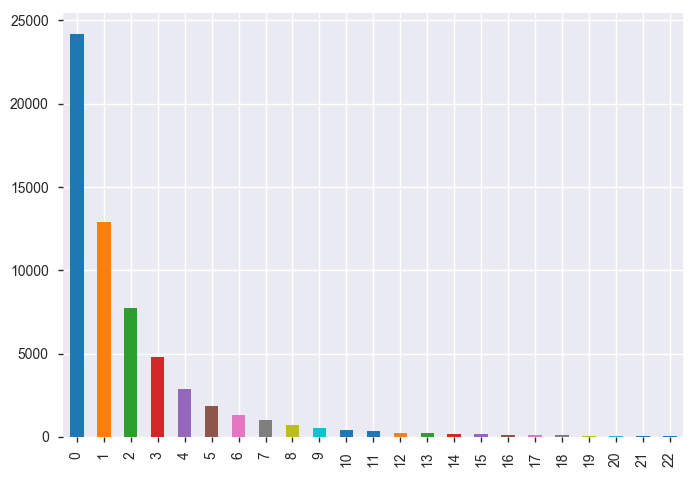

In [275]:
timedata['time_to_issue'].value_counts()[timedata['time_to_issue'].value_counts()>50].plot(kind='bar')

**Conclusion:  
Quick incident reporting times - usually reported immediately**

## EDA 3 - Initiated problem to Work Complete

In [276]:
deltas = []
# Looping through the Work Completion and Work Start to compare the time spent on repairs
for t1, t2 in zip(timedata['Initiated Date'],timedata['Work Completion Date']):
    tdelta = t2-t1
    deltas.append(tdelta)

In [277]:
timedata['3_deltas']= deltas

In [278]:
timedata['time_to_completion'] = timedata['3_deltas'].apply(lambda x: conv_time(x))

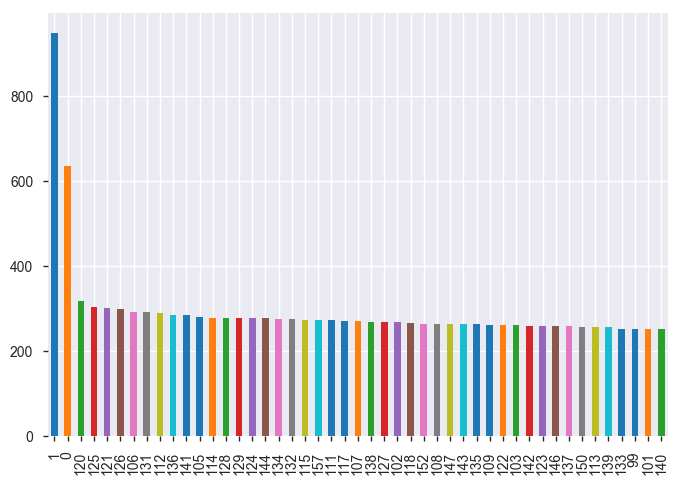

In [280]:
timedata['time_to_completion'].value_counts()[timedata['time_to_completion'].value_counts()>250].plot(kind='bar')

In [281]:
bins = [0, 50, 100, 200, 300, 400, 500, 600,1000]
timedata['3_binned'] = pd.cut(timedata['time_to_completion'], bins=bins)

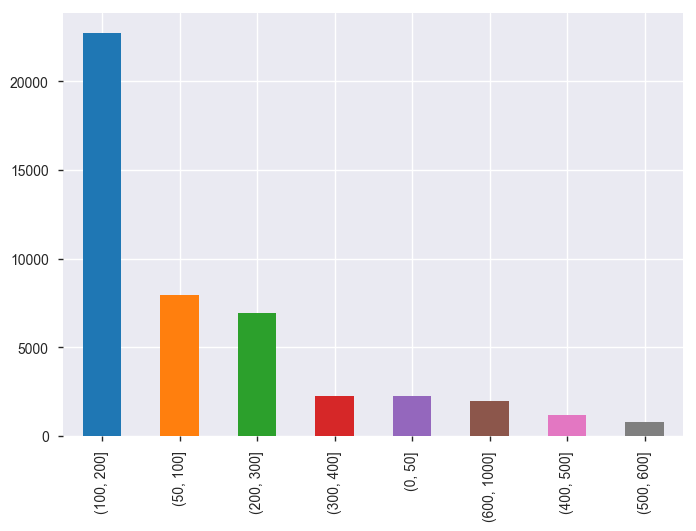

In [284]:
timedata['3_binned'].value_counts().plot(kind='bar')

**Conclusion:  
Majority of lifts are fixed with 3 hours**

# NLP Keyword to fault type analysis

In [288]:
textdata = data[['Fault External Reference','Block Name','Job User Specification','Site Name']]

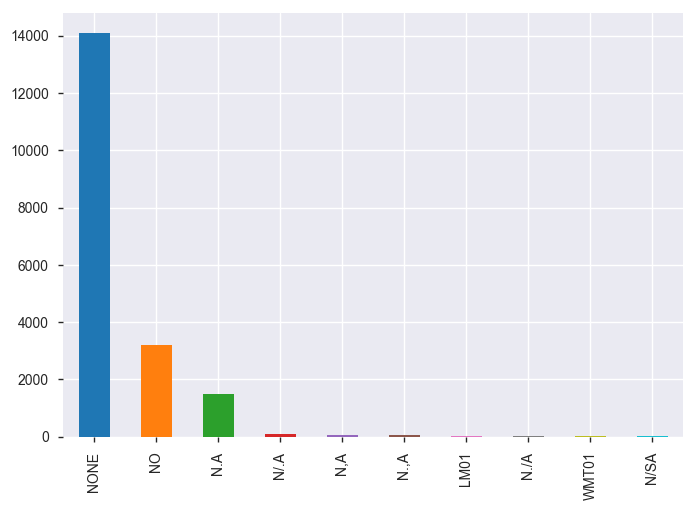

In [209]:
textdata['Fault External Reference'].value_counts().head(10).plot(kind='bar')

No relevant fault codes provided in dataset

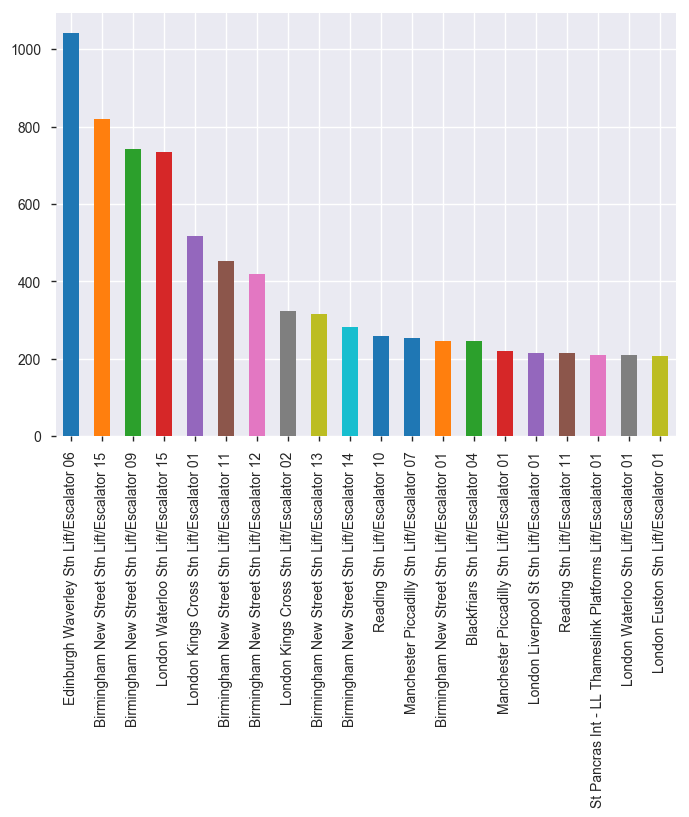

In [289]:
textdata['Block Name'].value_counts().head(20).plot(kind='bar')

Busiest Stations in the country have the highest lift failures. Inferred correlation between number of journeys and number of breakdowns.

In [386]:
EdinburghText = textdata['Job User Specification'][textdata['Block Name'] == "Edinburgh Waverley Stn Lift/Escalator 02"]

In [387]:
def tokenise(string):
    tokens = string.split()
    return tokens
    

In [388]:
tokenised = EdinburghText.apply(lambda x: tokenise(x))

In [389]:
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))

In [390]:
station_words = "Edinburgh Waverley Stn Lift/Escalator 02"
stop_words.append(station_words)

In [391]:
f_tokens =[tok for tok in tokenised if tok not in stop_words]

In [392]:
Edinburgh = [" ".join(sent) for sent in f_tokens]

In [393]:
Edinburgh_wc = " ".join(Edinburgh)

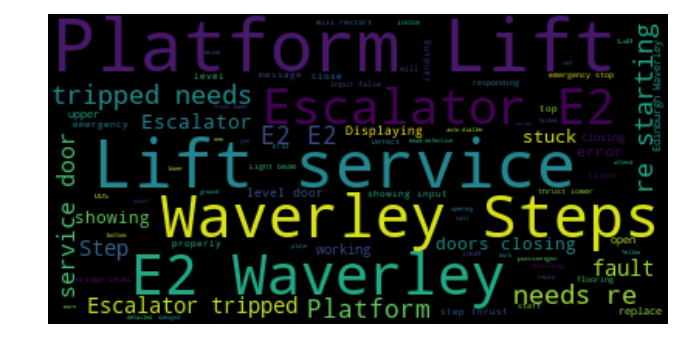

In [394]:
wordcloud = WordCloud().generate(Edinburgh_wc)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [395]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


In [399]:
get_top_n_words(Edinburgh, n=20)

[('lift', 86),
 ('e2', 84),
 ('out', 76),
 ('platform', 76),
 ('service', 63),
 ('escalator', 56),
 ('085889000476', 56),
 ('1316408', 55),
 ('of', 50),
 ('steps', 47),
 ('waverley', 43),
 ('has', 43),
 ('not', 41),
 ('the', 38),
 ('tripped', 29),
 ('needs', 28),
 ('re', 28),
 ('on', 28),
 ('doors', 27),
 ('starting', 26)]

**Conclusion:  
TO BE VALIDATED: If two numeric codes are Key Error codes or key part IDs - this can be of use for the next engineer**

# Lift Failure Analysis

In [2]:
logs = pd.read_csv("./../Downloads/TfL Lifts eventlog_01032019_26042019.csv", names=["Seq","Time","Priority","Desc", "Cause", "NMSID"],skiprows=1)

In [3]:
logs.head(7)

,Seq,Time,Priority,Desc,Cause,NMSID
0,1772501,26/04/2019 08:48:47,"""x""","""LCA LIFT 1 DOOR NORMAL Acknowledged by BRADF...","""Alarm_Acknowledged""",25442957
1,1772500,26/04/2019 08:48:42,"""x""","""LCA LIFT 1 DOOR NORMAL""","""Alarm_Cleared""",25442956
2,1772499,26/04/2019 08:48:36,"""1""","""LCA LIFT 1 DOOR FAULT""","""Alarm_Raised""",25442955
3,1772488,26/04/2019 08:41:12,"""x""","""WES LIFT 4 (ELITE) MAINTENANCE NORMAL Acknow...","""Alarm_Acknowledged""",25442944
4,1772487,26/04/2019 08:41:05,"""x""","""WES LIFT 4 (ELITE) MAINTENANCE NORMAL""","""Alarm_Cleared""",25442943
5,1772486,26/04/2019 08:40:57,"""3""","""WES LIFT 4 (ELITE) MAINTENANCE ALARM""","""Alarm_Raised""",25442942
6,1772468,26/04/2019 08:27:22,"""x""","""WOA NWR LIFT ALARM BUTTON NORMAL Acknowledge...","""Alarm_Acknowledged""",25442924


In [4]:
def remove_dead_string(val):
    value = val[2:-1]
    return value

In [5]:
logs["Priority"] = logs.Priority.apply(lambda x: remove_dead_string(x))

In [30]:
logs["Cause"] = logs["Cause"].apply(lambda x: remove_dead_string(x))

In [40]:
len(logs[logs["Cause"] =="Alarm_Acknowledged"])

13180

**FINDING 1: Over 13,000 Acknowledgments from TFL staff have occured but 99% of lift errors have lasted less than a minute (false positive)**

In [7]:
serious_failures['error_counts'] = (serious_failures['Priority'] == '1').cumsum()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#plt.plot(serious_failures.Time, serious_failures.error_counts) #PLOT TOO BIG

In [9]:
min(serious_failures['Time'])

' 01/03/2019 00:12:28'

In [11]:
max(serious_failures['Time'])

' 31/03/2019 23:49:55'

In [12]:
len(serious_failures)

15058

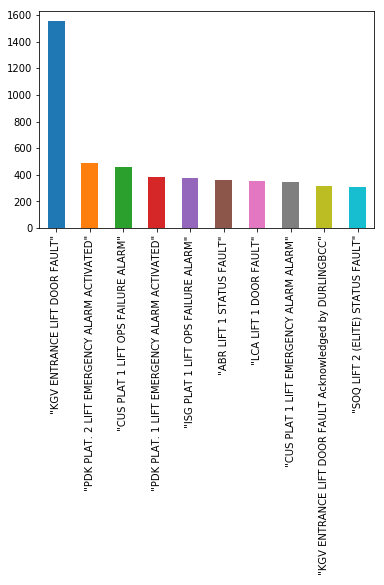

In [17]:
serious_failures.Desc.value_counts().head(10).plot(kind='bar')

**FINDING 2: Lift Door Faults are the highest false positive events**

As the lift is never out of operation following these events for very long - there are a large number of false positive alerts being set - which can be used to inform a CCTV machine learning model.

**USE CASE Explanation:**
By using the timestamps of the false positive moments and the CCTV camera feeds (+/- 5 seconds around the incident) - we can train a computer vision classifier to identify what is a false positive alert coming from the system and what should be raised to staff
    

# Analysing Oil Pressure in Lifts

In [21]:
logs['Desc'] = logs.Desc.apply(lambda x: remove_dead_string(x))

In [22]:
oils = 'KGV PLATFORM LIFT OIL PRESSURE NORMAL',  'KGV PLATFORM LIFT OIL PRESSURE HIGH',  'KGV PLATFORM LIFT OIL PRESSURE LOW'

In [24]:
logs[logs.Desc.isin(oils)]

,Seq,Time,Priority,Desc,Cause,NMSID
61,1772346,26/04/2019 06:50:30,x,KGV PLATFORM LIFT OIL PRESSURE NORMAL,"""Alarm_Cleared""",25442802
62,1772347,26/04/2019 06:50:30,x,KGV PLATFORM LIFT OIL PRESSURE NORMAL,"""Alarm_Cleared""",25442803
63,1772342,26/04/2019 06:50:28,1,KGV PLATFORM LIFT OIL PRESSURE LOW,"""Alarm_Raised""",25442798
65,1772344,26/04/2019 06:50:28,1,KGV PLATFORM LIFT OIL PRESSURE HIGH,"""Alarm_Raised""",25442800
70,1772332,26/04/2019 06:37:41,x,KGV PLATFORM LIFT OIL PRESSURE NORMAL,"""Alarm_Cleared""",25442788
71,1772333,26/04/2019 06:37:41,x,KGV PLATFORM LIFT OIL PRESSURE NORMAL,"""Alarm_Cleared""",25442789
73,1772329,26/04/2019 06:37:38,1,KGV PLATFORM LIFT OIL PRESSURE LOW,"""Alarm_Raised""",25442785
74,1772330,26/04/2019 06:37:38,1,KGV PLATFORM LIFT OIL PRESSURE HIGH,"""Alarm_Raised""",25442786
223,1769804,25/04/2019 23:40:55,x,KGV PLATFORM LIFT OIL PRESSURE NORMAL,"""Alarm_Cleared""",25440260
224,1769805,25/04/2019 23:40:55,x,KGV PLATFORM LIFT OIL PRESSURE NORMAL,"""Alarm_Cleared""",25440261


Anomalous Trend identified lift oil pressure, with alarms being raised for High Pressure and Low pressure before being cleared in under 3 seconds everytime.

This error is sequence is generated over 1k times in the analysed month of data accounting for 3.5 % of serious faults being raised

# L&E Asset Data

**L&E Asset Data provides all the elevators and escalators in the network - with a blank corresponding 'passenger count' number**

This is something that the CCTV ML model could help for by counting the number of passengers over a number of months to get more accurate estimates

# Maintenance - L&E Assets with Op Status 20.10.2017

Max No. Persons & Max Weight for lifts specs available

Can be inferred from Counting algorithm